# EasySFS Tutorial

## Outline
0. Basics of using Jupyter Notebooks
1. Basics of the SFS
2. Our dataset
3. Overview of `easySFS`
4. Build SFS from VCF file using `easySFS`
5. Accounting for the missing data using `easySFS`

-----
# 1. Basics of using Jupyter Notebooks

Jupyter Notebooks consist of cells where you can write Markdown or execute code. To run a cell, either click the "Run" button or press `Shift` + `Enter`.

By default, the cell contains Python code:

In [ ]:
print('Try writing some Python here')

It is possible to run command-line commands using magic `%%bash` at the beginning of a cell:

In [ ]:
%%bash
echo 'This is bash command'

-----
## 1. Basics of the SFS

### What data do we need for demographic inference?

- VCF with **biallelic single nucleotide variants**
- As many SNP's as possible
- As many individuals as possible (8-10 okay, 100 better)
- Remove relatives
- Use neutral sites or intergenic regions (similar evolution forces)
- Remove multiallelic, indels
- No MAF-filtering (!)
- ~~Avoid missing data~~ (`easySFS` and `ATLAS` can help with missing data)

### What is the SFS?

Site frequency spectrum or allele frequency spectrum is a joint distribution of allele frequencies among population.

- One population. SFS is vector $S$ of values, Entry $S[i]$ contains number of positions where derived allele occured in $i$ hyplotype samples.
<div>
<img src="pictures/1d_plot.png" width="300" align="left" />
</div>

- Two populations. SFS is a 2-dimentional matrix where entry $S[i, j]$ corresponds to the number of positions where the derived alleles occured in $i$ haplotype samples in population 1 and in $j$ haplotype samples in population 2.
<div>
<img src="pictures/2d_plot.png" width="250" align="left" />
</div>

- $P$ populations. SFS is a $P$-dimentional tensor. Example for three populations:
<div>
<img src="pictures/3d_plot.png" width="300" align="left" />
</div>

### Ignore monomorphic bins

SFS bin that corresponds to the frequency 0 per population contains number of monomorphic positions with the ancestral allele. Some tools (`dadi`, `moments`, `momi2`) ignore that value as it could be easily evaluated from total sequence length and other values of SFS.

For almost the same reason the bin with maximum frequency per population is excluded from the analisys. The number of sites with fixed derived allele is relatively small and, moreover, could be a consequence of false ancestral allele identification.

On the plots above both monomorphic bins are excluded. The monomorphic bin with 0 frequency is usually very high as most sites are monomorphic, and, thus, including it to the plot will lead to the severe disproportions of other bins.

### What if we do not know the derived allele? (SFS folding)

Sometimes outgroup information is missed. In that case we can use minor allele frequencies (MAF) to build our SFS. The MAF SFS can be easily built from the usual SFS. This process is called *folding* and MAF SFS is called *folded SFS*.

- Example of the SFS folding in case of one population:

    Unfolded and folded SFS correspondingly:

    <img src="pictures/1d_plot_before_folding.png" width="300" align="left"/>
    <img src="pictures/1d_plot_after_folding.png" width="300" align="left"/>

- Example of the SFS folding in case of two populations:

    Unfolded and folded SFS correspondingly:
    
    <img src="pictures/2d_plot_before_folding.png" width="250" align="left"/>
    <img src="pictures/2d_plot_after_folding.png" width="250" align="left"/>

-----
## 2.  Our dataset

We have a dataset for clouded leopards (*Neofelis nebulosa*). It is an example data for one contig (10,000,000 bp) for 10 diploid individuals (20 haploid samples).

All the data is available in the `data` folder:

In [2]:
%%bash
ls data

example_data.vcf
popmap.txt


- File `data/example_data.vcf` is our VCF file for all 10 individuals (single chromosome of 10,000,000 bp):

In [4]:
%%bash
# First five lines
head -6 data/example_data.vcf

##fileformat=VCFv4.2
##FILTER=<ID=PASS,Description="All filters passed">
##source=tskit 0.5.7
##contig=<ID=CONTIG1,length=10000000>
##FORMAT=<ID=GT,Number=1,Type=String,Description="Genotype">
#CHROM	POS	ID	REF	ALT	QUAL	FILTER	INFO	FORMAT	Leopard01	Leopard02	Leopard03	Leopard04	Leopard05	Leopard06	Leopard07	Leopard08	Leopard09	Leopard10


In [5]:
%%bash
# The header line of the VCF file (we take first 84 lines of file and then show the last one)
head -6 data/example_data.vcf | tail -1

#CHROM	POS	ID	REF	ALT	QUAL	FILTER	INFO	FORMAT	Leopard01	Leopard02	Leopard03	Leopard04	Leopard05	Leopard06	Leopard07	Leopard08	Leopard09	Leopard10


- File `data/popmap.txt` provides population assignments per individual (all our individuals are from the same population that is marked as `NN`):

In [6]:
%%bash
cat data/popmap.txt

Leopard01 NN
Leopard02 NN
Leopard03 NN
Leopard04 NN
Leopard05 NN
Leopard06 NN
Leopard07 NN
Leopard08 NN
Leopard09 NN
Leopard10 NN


-----
## 3. VCF filtering
We require VCF with **biallelic single-nucleotide** variants. The example VCF already has SNPs only. If your VCF contains multi-nucleotide variants, then it is better to do [VCF normalization](https://samtools.github.io/bcftools/bcftools.html#norm) (with `--fasta-ref` option if possible).

Having our VCF file we can filter all mutiallelic, multi-nucleotide variants and indels using bcftools (you can easily install it via `conda install bcftools`).

Remove monomorphic sites (monomorphic for both alleles):

In [7]:
%%bash
bcftools view -e 'COUNT(GT="AA")=N_SAMPLES || COUNT(GT="RR")=N_SAMPLES' data/example_data.vcf > data/polymorphic_snps.vcf

Leave biallelic SNPs only:

In [8]:
%%bash
bcftools view -m2 -M2 -v snps data/polymorphic_snps.vcf -Ov -o data/biallelic_snps.vcf

We can get the total number of variants we have:

In [9]:
%%bash
bcftools view -H data/biallelic_snps.vcf | wc -l

543220


**We will use this value later to calculate the length of sequence for GADMA.**

-----
## 3. Overview of `easySFS`

### What is [easySFS](https://github.com/isaacovercast/easySFS#install--run)?
- A tool for SFS construction from the VCF file.
- Generates SFS in several formats: `dadi`/`fastsimcoal2`/`momi2` (GADMA accepts all of them)
- Provides means to project SFS down to account for missed data.
- Allows to focus SFS on the independent SNP's (for RADSeq-like data only!)

(Unfortunately, no paper to cite, however, authors ask to credit [\[Gutenkunst et al. 2009\]](https://doi.org/10.1371/journal.pgen.1000695))

### Installation

Resources: [more information about installation of easySFS](https://github.com/isaacovercast/easySFS#install--run)

Download `easySFS` from GitHub repo:

In [6]:
%%bash
git clone https://github.com/isaacovercast/easySFS.git
ls easySFS

fatal: destination path 'easySFS' already exists and is not an empty directory.


easySFS.py
example_files
jupyter-notebooks
__pycache__
README.md
Spectrum.py


-----
## 4. Build SFS from VCF file using `easySFS`

First we will build full-sized SFS from VCF file using SFS. For that purpose we will use `--proj` option.

First we will create the directory to store our output:

In [11]:
%%bash
rm -rf outputs
mkdir outputs

### Run `easySFS` with the `--help` option

In [10]:
%%bash
./easySFS/easySFS.py --help

usage: easySFS.py [-h] -i VCF_NAME -p POPULATIONS [-o OUTDIR]
                  [--proj PROJECTIONS] [--preview] [--ploidy PLOIDY]
                  [--prefix PREFIX] [--unfolded] [--order POP_ORDER]
                  [--dtype DTYPE] [--GQ GQUAL] [--total-length TOTAL_LENGTH]
                  [--window-bp WINDOW_BP] [--window-snp WINDOW_SNP] [-a] [-f]
                  [-y] [-v]

options:
  -h, --help            show this help message and exit
  -i VCF_NAME           name of the VCF input file being converted
  -p POPULATIONS        Input file containing population assignments per
                        individual
  -o OUTDIR             Directory to write output SFS to
  --proj PROJECTIONS    List of values for projecting populations down to
                        different sample sizes
  --preview             Preview the number of segragating sites per population
                        for different projection values.
  --ploidy PLOIDY       Specify ploidy. Default is 2. Only oth

### Run easySFS for your VCF file with `--proj` option

We use `--proj 20` as we have 10 diploid samples.

We add the following options:
* `-a` to use all SNPs, otherwise easySFS randomly chooses one SNP per contig as it was developed for RADseq data
* `--unfolded` to construct unfolded spectrum
* `-o outputs/easySFS_output` to write output in this directory
* `-f` to rewrite if the output directory exists
* **Do not use** `--total-length 10000000` (unless you know what you are doing)

In [13]:
%%bash
./easySFS/easySFS.py -i data/biallelic_snps.vcf -p data/popmap.txt -a --unfolded -o outputs/easySFS_output -f --proj 20

## easySFS output
EasySFS with `--proj` option generates SFS for a given data in several formats:
- `dadi` - input format of dadi, moments,
- `fastsimcoal2` - input format of fastsimcoal2,
- `momi` - input format of momi2 (only if we use full projections, i.e. do not project SFS down).

GADMA can work with any input format mentioned above.

In [21]:
%%bash
ls outputs/easySFS_output

dadi
datadict.txt
fastsimcoal2


In [22]:
%%bash
ls outputs/easySFS_output/dadi

NN-20.sfs
NN.sfs


In [23]:
%%bash
cat outputs/easySFS_output/dadi/NN-20.sfs

21 unfolded "NN"
0 28664 22013 20316 15907 12781 11497 10606 9570 8389 7195 7002 6441 5816 5188 4918 4690 4626 4029 4042 0
1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1


In [24]:
%%bash
cat outputs/easySFS_output/fastsimcoal2/NN_DAFpop0.obs

1 observation
d0_0	d0_1	d0_2	d0_3	d0_4	d0_5	d0_6	d0_7	d0_8	d0_9	d0_10	d0_11	d0_12	d0_13	d0_14	d0_15	d0_16	d0_17	d0_18	d0_19	d0_20
0 28664 22013 20316 15907 12781 11497 10606 9570 8389 7195 7002 6441 5816 5188 4918 4690 4626 4029 4042 0



## Picture of our SFS

In this example we will use SFS `output/dadi/NN.sfs` generated for dadi. Let us draw the picture:

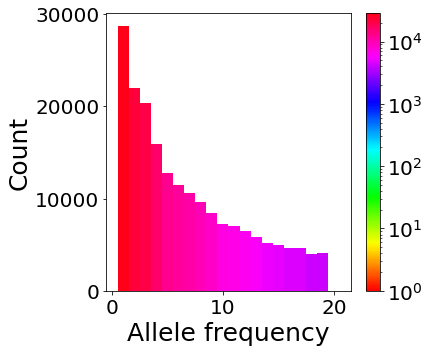

In [25]:
from scripts.draw_sfs import draw_1d_sfs
draw_1d_sfs("outputs/easySFS_output/dadi/NN-20.sfs")

You can use this script from command line:

In [26]:
%%bash
python scripts/draw_sfs.py --help

usage: draw_sfs.py [-h] [-o OUTPUT] dadi_sfs_file

Plot 1d/2d/3d dadi/moments SFS and either display or save to file.

positional arguments:
  dadi_sfs_file         dadi SFS file

options:
  -h, --help            show this help message and exit
  -o OUTPUT, --output OUTPUT
                        Output file for plot (optional, otherwise pops up a
                        window)


In [27]:
%%bash
python scripts/draw_sfs.py -o outputs/my_sfs_full.pdf outputs/easySFS_output/dadi/NN-20.sfs

/home/enoskova/Workspace/GADMA_workshops/2025-12-Demographic_Inference_Worshop/tutorials/1_easySFS_tutorial/scripts/draw_sfs.py:79: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fs = moments.Spectrum.from_file(input_file)
/home/enoskova/Workspace/GADMA_workshops/2025-12-Demographic_Inference_Worshop/tutorials/1_easySFS_tutorial/scripts/draw_sfs.py:14: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fs = moments.Spectrum.from_file(input_file)


[INFO] Saved: outputs/my_sfs_full.pdf


## Number of SNPs in SFS

We can get the number of segregating sites that were used to build SFS by summarising all entries of the SFS (this works only the option `--total-length` was not used):

In [28]:
%%bash
awk 'NR==2 {for(i=1;i<=NF;i++) sum+=$i} END{print sum}' outputs/easySFS_output/dadi/NN-20.sfs

193690


Knowing the total number of SNPs in our full biallelic VCF file, we can get the fraction of SNPs that were used to build SFS: $193690 / 543220 = 35.6\%$.

The latter value 543220 was calculated in `1_data_checks_tutorial`.

-----
## 5. Accounting for the missing data using `easySFS`

### What is the SFS projection?
Assume we have two different datasets with different numbers of samples. We construct two SFS and want to compare them, but they are of different size. SFS is a histogram of allele frequencies and it is possible to downsize or project it. Thus, we could downsize both spectra to some smaller size and compare them.

### Some intuition about SFS projection

Let us get some intuition about how to use information from the bigger SFS for its projection.

Assume we have the following data ($A$ stands for ancestral allele and $T$ for derived allele):

- Sample 1: $A\ A\ A\ T\ A$
- Sample 2: $A\ A\ T\ A\ A$
- Sample 3: $A\ A\ T\ T\ \ .$
- Sample 4: $T\ A\ T\ A\ A$

and we want to build projection of the SFS on three samples.

We can see that the derived allele has frequency of $1/4$ (one out of four) among four samples on the first position.
Let us subsample three individuals from given four samples and compute the frequency of derived allele on the first position. We can choose samples 1, 2, 3 and obtain $0/3$ frequency (with probability $p_1=0.75$) or we can obtain frequency of $1/3$ by choosing sample 4 and any other two samples (with probability $p_2 = 0.25$).

Thus, for our SFS projection we can put value equal to $p_1$ in the $0/3$ bin and value of $p_2$ in the $1/3$ bin.

The third position has derived allele frequency of $3/4$. We can obtain frequency of $3/3$ by choosing samples 2, 3, 4 and frequency of $2/3$ by choosing sample 1 and any other two samples.

Having the probabilities of each subsampling frequency (see [hypergeometric distribution](https://en.wikipedia.org/wiki/Hypergeometric_distribution)) we can build new SFS with smaller size.

### Accounting for the missed data

SFS projection can easy account for missed information! For the last position in our example data we just add $1$ to the frequency $0/3$ of the projected SFS. That is exactly what `easySFS` does.

### Warning
We cannot use downprojection trick when **ploidy>2** or **we have inbred (selfing) species**. Build a full-sized SFS in that cases.

### Run `easySFS` for your VCF file with `--preview` option

Run easySFS, save the output in `outputs/easySFS_preview_output`:

In [29]:
%%bash
python easySFS/easySFS.py -i data/biallelic_snps.vcf -p data/popmap.txt -a --preview > outputs/easySFS_preview_output
cat outputs/easySFS_preview_output


  Processing 1 populations - ['NN']

    Running preview mode. We will print out the results for # of segregating sites
    for multiple values of projecting down for each population. The dadi
    manual recommends maximizing the # of seg sites for projections, but also
    a balance must be struck between # of seg sites and sample size.

    For each population you should choose the value of the projection that looks
    best and then rerun easySFS with the `--proj` flag.
    
NN
(2, 178973)	(3, 268460)	(4, 324848)	(5, 364687)	(6, 394794)	(7, 418574)	(8, 437963)	(9, 454080)	(10, 467825)	(11, 479034)	(12, 489356)	(13, 493294)	(14, 501290)	(15, 480294)	(16, 486384)	(17, 392786)	(18, 396810)	(19, 192055)	(20, 193690)	



#### Visualize the results of the preview
In this notebook we will use python:

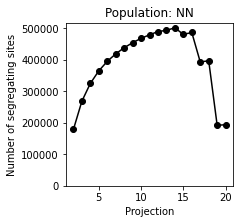

In [30]:
from scripts.draw_easySFS_preview import draw_easySFS_preview
draw_easySFS_preview("outputs/easySFS_preview_output")

Moreover, one can run script from command line the following way (the same picture will appear in `outputs/my_easySFS_preview.pdf` if you use it from the command line interface):

In [31]:
%%bash
python scripts/draw_easySFS_preview.py --output outputs/my_easySFS_preview.pdf outputs/easySFS_preview_output

[INFO] Saved: outputs/my_easySFS_preview.pdf


### Run easySFS for your VCF file with `--proj` option

We use `--proj 14` option instead `--preview`.

We add the following options:
* `-a` to use all SNPs, otherwise easySFS randomly chooses one SNP per contig as it was developed for RADseq data
* `--unfolded` to construct unfolded spectrum
* `-o outputs/easySFS_output` to write output in this directory
* `-f` to rewrite if the output directory exists
* **Do not use** `--total-length 10000000` (unless you know what you are doing)

In [32]:
%%bash
./easySFS/easySFS.py -i data/biallelic_snps.vcf -p data/popmap.txt -a --unfolded -o outputs/easySFS_output -f --proj 14


  Processing 1 populations - ['NN']
  SFS files written to /home/enoskova/Workspace/GADMA_workshops/2025-12-Demographic_Inference_Worshop/tutorials/1_easySFS_tutorial/outputs/easySFS_output



### Run easySFS for your VCF file with `--proj` option

We use `--proj 14` option instead `--preview`.

We add the following options:
* `-a` to use all SNPs, otherwise easySFS randomly chooses one SNP per contig as it was developed for RADseq data
* `--unfolded` to construct unfolded spectrum
* `-o outputs/easySFS_output` to write output in this directory
* `-f` to rewrite if the output directory exists
* **Do not use** `--total-length 10000000` (unless you know what you are doing)

### Picture of our SFS

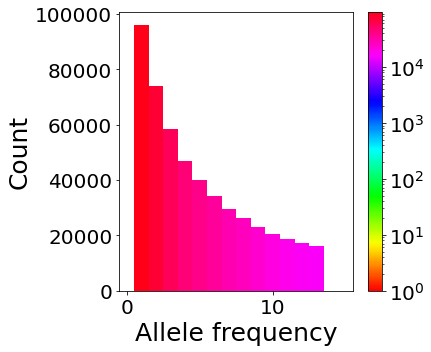

In [33]:
from scripts.draw_sfs import draw_1d_sfs
draw_1d_sfs("outputs/easySFS_output/dadi/NN-14.sfs")

To run the script from command line:

In [34]:
%%bash
python scripts/draw_sfs.py -o outputs/my_sfs_downprojected_14.pdf outputs/easySFS_output/dadi/NN-14.sfs

/home/enoskova/Workspace/GADMA_workshops/2025-12-Demographic_Inference_Worshop/tutorials/1_easySFS_tutorial/scripts/draw_sfs.py:79: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fs = moments.Spectrum.from_file(input_file)
/home/enoskova/Workspace/GADMA_workshops/2025-12-Demographic_Inference_Worshop/tutorials/1_easySFS_tutorial/scripts/draw_sfs.py:14: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fs = moments.Spectrum.from_file(input_file)


[INFO] Saved: outputs/my_sfs_downprojected_14.pdf


### Number of SNPs in SFS

We can get the number of segregating sites that were used to build SFS by summarising all entries of the SFS (this works only the option `--total-length` was not used):

In [35]:
%%bash
awk 'NR==2 {for(i=1;i<=NF;i++) sum+=$i} END{print sum}' outputs/easySFS_output/dadi/NN-14.sfs

536796


Knowing the total number of SNPs in our full VCF file, we can get the fraction of SNPs that were used to build SFS: $536796 / 543220 = 98.8\%$.

The latter value 543220 was calculated in `1_data_checks_tutorial`.

-----
## 4. Hands On: Build SFS for Orangutan Dataset

You can follow the step-by-step tutorial using the same example dataset demonstrated above (e.g. build folded SFS for clouded leopard), or try it on a **different dataset** for additional practice. You can also use this dataset throughout the GADMA tutorial.

For the practical sessions, we provide genetic data from two populations of orangutans. The example dataset includes:

* VCF file (`chr1.vcf.gz`): Contains SNP data for chromosome 1, which is 227,913,704 base pairs long.
* Popmap file (`popmap.txt`): Indicates the population assignment for each sample. There are two populations—Bornean and Sumatran orangutans—with 10 samples each.
* The mutation rate is set to 1.5 × 10⁻⁸ per base pair per generation (we will need that later for the GADMA tutorial).